In [1]:
%load_ext autoreload
%autoreload 2
from analysis_utils import prepare_df, aggregate_by_fields
import json
import numpy as np
from datasets import load_dataset
from analysis_utils import *

In [2]:
def get_verdict_ids_from_batch(verdict_group_batch):
    with open(f"../results/verdict_groups/{verdict_group_batch}.json", "r") as f:
        data = json.load(f)

    verdict_ids = []
    for run in data["runs"]:
        verdict_ids.append(run['verdict_run_id'])

    return verdict_ids, data

Plot 1

In [3]:
verdict_group_batch = "82ifg57"
verdict_ids, _ = get_verdict_ids_from_batch(verdict_group_batch)

In [4]:
verdicts_df = prepare_df(specific_verdict_ids=verdict_ids)
verdicts_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]


/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)
/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


In [5]:
aggregate_acc = aggregate_by_fields(verdicts_df, fields=['config_model_name_qa_judge'])
aggregate_acc = aggregate_acc.iloc[0:-1:4]


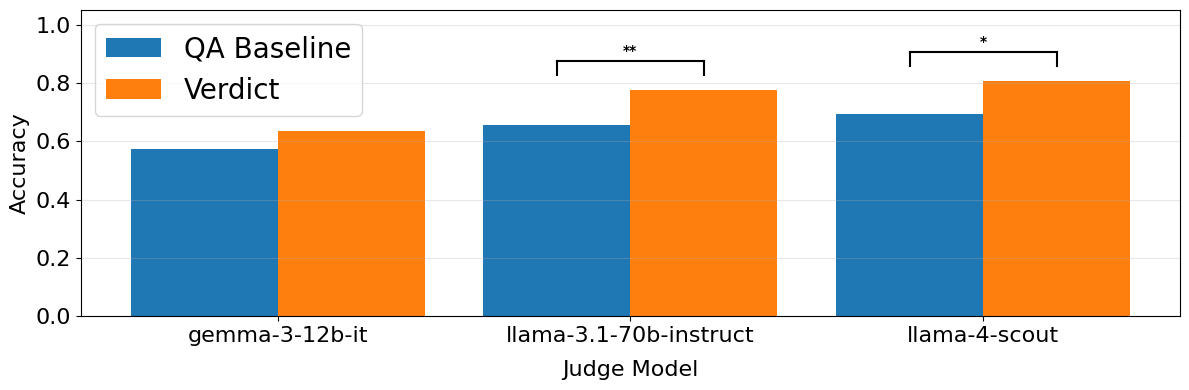

In [6]:
from plot_utils import *
aggregate_acc = aggregate_acc[aggregate_acc['name'] != 'x-ai/grok-4-fast']
plot_results_by_name(aggregate_acc, plot_gap_and_gain=False)
plt.show()

Plot 2

In [43]:
verdict_group_batch = "4r30ivy"
verdict_ids, data = get_verdict_ids_from_batch(verdict_group_batch)

In [44]:
verdict_ids

['1fj2i05',
 'juku5ze',
 'qglv702',
 '2w6ge2u',
 '6pimftp',
 't9icnd3',
 'b8gewd2',
 'krk0a9q',
 '7qy5yv0',
 'khnl8h5',
 '04b8m8o']

In [45]:
verdicts_df = prepare_df(specific_verdict_ids=verdict_ids)
verdicts_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/../analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


In [46]:
aggregate_acc = aggregate_by_fields(verdicts_df, fields=['verdict_run_id_verdicts'])

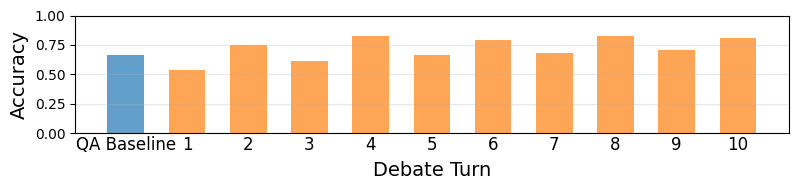

In [53]:
for run_idx in [0]:
    run_mapping = pd.DataFrame(data['runs'])
    merged = aggregate_acc.merge(run_mapping, left_on='name', right_on='verdict_run_id')
    plot_data = merged[merged['run_idx'] == run_idx].copy()
    
    if 'upto_turns' in plot_data.columns:
        upto_turns_list = sorted([x for x in plot_data['upto_turns'].dropna().unique()])
        # upto_turns_list = upto_turns_list[:-6]
        upto_turns_list = upto_turns_list
        upto_turns_list = [x for x in upto_turns_list if x != 0]
    else:
        upto_turns_list = [None]
    
    n_bars = 1 + len(upto_turns_list)
    x = np.arange(n_bars)
    width = 0.6
    
    fig, ax = plt.subplots(figsize=(8, 2))
    
    rows = plot_data
    judge_qa_value = rows['judge_qa_acc'].mean()
    judge_qa_n_correct = int(rows['judge_qa_n_correct'].sum())
    judge_qa_n_total = int(rows['n_judge_qa_not_null'].sum())
    
    bar_judge_qa = ax.bar(0, judge_qa_value, width, label='QA Baseline', alpha=0.7, color='C0')
    ax.text(0, -0.02, 'QA Baseline', ha='center', va='top', fontsize=12)
    
    for i, upto_turns in enumerate(upto_turns_list):
        if upto_turns is not None:
            turn_data = plot_data[plot_data['upto_turns'] == upto_turns].copy()
        else:
            turn_data = plot_data.copy()
        
        if len(turn_data) > 1:
            raise Exception('Check why rows greater than 1')
        
        verdict_value = turn_data.iloc[0]['verdict_acc']
        verdict_n_correct = int(turn_data.iloc[0]['verdict_n_correct'])
        verdict_n_total = int(turn_data.iloc[0]['n_verdict_not_null'])
        
        bar_idx = i + 1
        label = f"{upto_turns if upto_turns is not None else 'All'} Turns"
        bar = ax.bar(bar_idx, verdict_value, width, label=label, alpha=0.7, color='C1')
        
        turn_label = f"{upto_turns if upto_turns is not None else 'All'}"
        ax.text(bar_idx, -0.02, turn_label, ha='center', va='top', fontsize=12)
    
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xlabel('Debate Turn', fontsize=14, labelpad=20)
    ax.set_xticks([])
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    # ax.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()

Plot 3

In [12]:
debate_run_id = 'suu380s'
df = prepare_df(['debates'])
df = df[df['run_id_debates'] == debate_run_id]
df.shape

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


(197, 49)

In [54]:
correct_debater_response_times = []
incorrect_debater_response_times = []
correct_reasoning_tokens = []
incorrect_reasoning_tokens = []
from collections import defaultdict
correct_by_turn_dict = defaultdict(list)
incorrect_by_turn_dict = defaultdict(list)
correct_reasoning_by_turn_dict = defaultdict(list)
incorrect_reasoning_by_turn_dict = defaultdict(list)
for idx, row in df.iterrows():
    correct_idx = row['correct_idx_debates']
    num_correct_turns = 0
    num_incorrect_turns = 0
    for turn in row['debate_history_debates']:
        reasoning_tokens = get_reasoning_tokens(turn)
        if turn['debater_idx'] == correct_idx:
            correct_debater_response_times.append(turn['response_time'])
            correct_reasoning_tokens.append(reasoning_tokens)
            correct_by_turn_dict[num_correct_turns].append(turn['response_time'])
            correct_reasoning_by_turn_dict[num_correct_turns].append(reasoning_tokens)
            num_correct_turns += 1
        elif turn['debater_idx'] != correct_idx:
            incorrect_debater_response_times.append(turn['response_time'])
            incorrect_reasoning_tokens.append(reasoning_tokens)
            incorrect_by_turn_dict[num_incorrect_turns].append(turn['response_time'])
            incorrect_reasoning_by_turn_dict[num_incorrect_turns].append(reasoning_tokens)
            num_incorrect_turns += 1
correct_debater_response_times = pd.Series(correct_debater_response_times)
incorrect_debater_response_times = pd.Series(incorrect_debater_response_times)
correct_reasoning_tokens = pd.Series(correct_reasoning_tokens)
incorrect_reasoning_tokens = pd.Series(incorrect_reasoning_tokens)

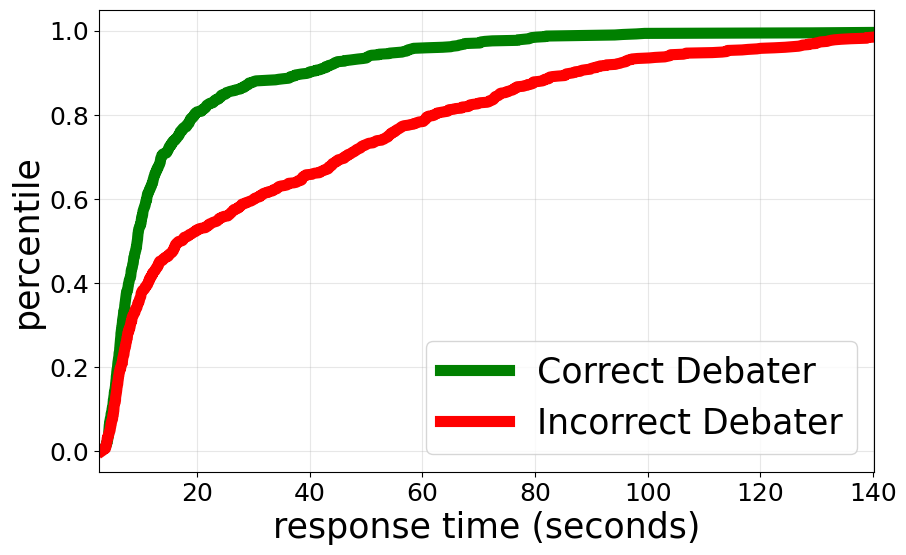

In [55]:
ax = cdf((correct_debater_response_times, incorrect_debater_response_times), labels=['Correct Debater', 'Incorrect Debater'], xlim_percentiles=[0, 99])
plt.xlabel('response time (seconds)', fontsize=25)
plt.ylabel('percentile', fontsize=25)
plt.show()

Plot 4

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')
from analysis.analysis_utils import *

human_verdicts_file = '../results/human/human_verdicts.jsonl'
human_df = pd.read_json(human_verdicts_file, lines=True)

run_id = '0vayjit'
human_df = human_df[human_df['run_id'] == run_id]

debates_df = prepare_df(['debates'])
debates_df = debates_df[debates_df['run_id_debates'] == run_id]

merged = human_df.merge(debates_df[['run_id_debates', 'record_id_debates', 'correct_idx_debates']], 
                        left_on=['run_id', 'record_id'], 
                        right_on=['run_id_debates', 'record_id_debates'])

merged['verdict'] = merged['verdict'].astype(int)
merged['correct_idx_debates'] = merged['correct_idx_debates'].astype(int)
merged['confidence'] = merged['confidence'].astype(float) / 100.0

merged['is_correct'] = merged['verdict'] == merged['correct_idx_debates']

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/../analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


Accuracy: 0.889
Brier Score: 0.0711
Baseline Brier Score (always predict 0.5): 0.2500


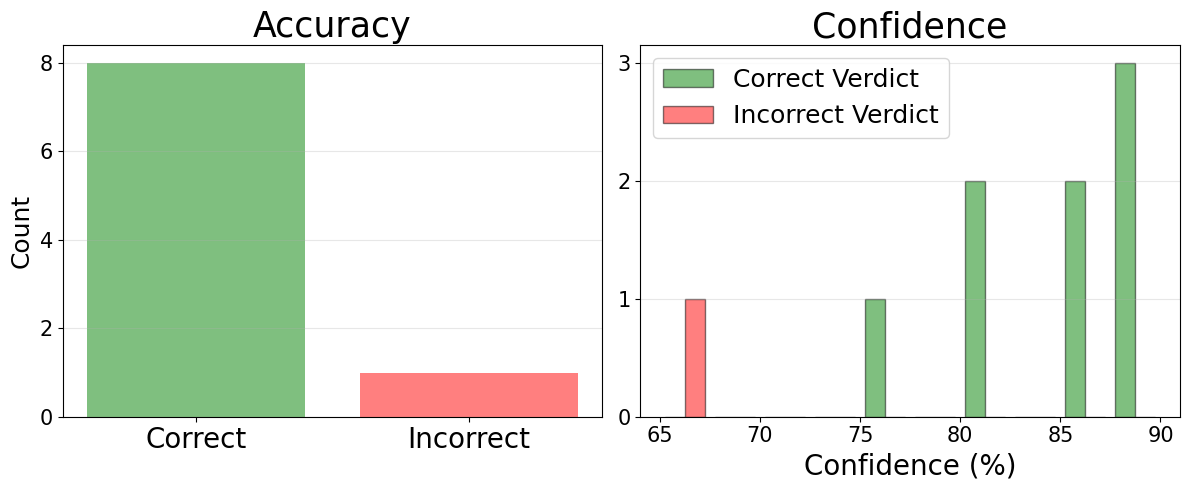


Brier Score: 0.0711
Baseline Brier Score: 0.2500
Improvement: 0.1789


In [ ]:
def compute_brier_score(merged_df):
    brier_scores = []
    for _, row in merged_df.iterrows():
        verdict = row['verdict']
        confidence = row['confidence']
        correct = row['correct_idx_debates']
        
        if verdict == correct:
            predicted_prob_correct = confidence
        else:
            predicted_prob_correct = 1.0 - confidence
        
        actual = 1.0
        brier_score = (predicted_prob_correct - actual) ** 2
        brier_scores.append(brier_score)
    
    return np.mean(brier_scores)

accuracy = merged['is_correct'].mean()
print(f"Accuracy: {accuracy:.3f}")

brier_score = compute_brier_score(merged)
print(f"Brier Score: {brier_score:.4f}")

baseline_brier = 0.25
print(f"Baseline Brier Score (always predict 0.5): {baseline_brier:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(['Correct', 'Incorrect'], [merged['is_correct'].sum(), (~merged['is_correct']).sum()], 
        color=['green', 'red'], alpha=0.5)
ax1.set_ylabel('Count', fontsize=18)
# ax1.set_title(f'Accuracy: {accuracy:.1%}', fontsize=14, fontweight='bold')
ax1.set_title(f'Accuracy',  fontsize=25)

ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=20)


correct_conf = merged[merged['is_correct']]['confidence'] * 100
incorrect_conf = merged[~merged['is_correct']]['confidence'] * 100

ax2.hist([correct_conf, incorrect_conf], bins=10, alpha=0.5, 
         label=['Correct Verdict', 'Incorrect Verdict'], color=['green', 'red'], edgecolor='black')
ax2.set_xlabel('Confidence (%)', fontsize=20)
ax2.set_title('Confidence', fontsize=25)
ax2.legend(fontsize=18)
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='both', labelsize=15)
ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

print(f"\nBrier Score: {brier_score:.4f}")
print(f"Baseline Brier Score: {baseline_brier:.4f}")
print(f"Improvement: {baseline_brier - brier_score:.4f}")

Comparison to LLM brier score

In [28]:
# verdict_group_batch = "82ifg57"
verdict_group_batch = "6irkzm1"
# verdict_group_batch = "gp61skb"
# verdict_group_batch = "xod46dv"
verdict_ids, _ = get_verdict_ids_from_batch(verdict_group_batch)
verdicts_df = prepare_df(specific_verdict_ids=verdict_ids)
verdicts_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]
verdicts_df = verdicts_df[(verdicts_df['config_model_name_qa_judge'] != 'meta-llama/llama-4-scout') & (verdicts_df['config_model_name_qa_debater'] != 'meta-llama/llama-4-scout')]
verdicts_df = verdicts_df[(verdicts_df['config_model_name_qa_judge'] != 'meta-llama/llama-3.1-405b-instruct') & (verdicts_df['config_model_name_qa_debater'] != 'meta-llama/llama-3.1-405b-instruct')]
# remove the cases where grok-4 or llam-4 are judges 
verdicts_df = verdicts_df[~verdicts_df['config_judge_model_verdicts'].isin(['x-ai/grok-4-fast', 'meta-llama/llama-4-maverick'])]
# and only keep cases where grok-4 or llama-4 are debaters
verdicts_df = verdicts_df[verdicts_df['config_model_name_qa_debater'].isin(['x-ai/grok-4-fast', 'meta-llama/llama-4-maverick'])]



/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


In [29]:
verdicts_df['config_model_name_qa_debater'].value_counts()

config_model_name_qa_debater
meta-llama/llama-4-maverick    1690
x-ai/grok-4-fast               1681
Name: count, dtype: int64

In [30]:
temp_df = verdicts_df[verdicts_df['parsed_confidence_verdicts'].notnull()].copy()
print(f"Total rows: {len(temp_df)}")
print(f"Null confidence: {temp_df['parsed_confidence_verdicts'].isnull().sum()}")

def compute_brier_score(df):
    brier_scores = []
    for _, row in df.iterrows():
        confidence = row['parsed_confidence_verdicts'] / 100.0
        is_correct = row['is_correct_verdict']
        
        if is_correct:
            predicted_prob_correct = confidence
        else:
            predicted_prob_correct = 1.0 - confidence
        
        actual = 1.0
        brier_score = (predicted_prob_correct - actual) ** 2
        brier_scores.append(brier_score)
    
    return np.mean(brier_scores)

brier_score = compute_brier_score(temp_df)
baseline_brier = 0.25

print(f"Brier Score: {brier_score:.4f}")
print(f"Baseline Brier Score: {baseline_brier:.4f}")
print(f"Improvement: {baseline_brier - brier_score:.4f}")


Total rows: 3367
Null confidence: 0
Brier Score: 0.2733
Baseline Brier Score: 0.2500
Improvement: -0.0233


In [32]:
# (0.2164 - 0.0711) / .2164
(.2733 - .0711) / .2733

0.7398463227222832

Plot 5

In [29]:
verdict_group_batch = "6irkzm1"
# verdict_group_batch = "0h2y5kw" # separate correct and incorrect
# verdict_group_batch = "cm97fj8" # gemini-3-preview debates with varying reasoning levels
verdict_ids, data = get_verdict_ids_from_batch(verdict_group_batch)
verdicts_df = prepare_df(specific_verdict_ids=verdict_ids, filter_debates_with_any_failed_turns=True)
print(verdicts_df.shape)
# verdicts_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]
verdicts_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull())]
print(verdicts_df.shape)

verdicts_df = verdicts_df[(verdicts_df['config_model_name_qa_judge'] != 'meta-llama/llama-4-scout') & (verdicts_df['config_model_name_qa_debater'] != 'meta-llama/llama-4-scout')]
print(verdicts_df.shape)

verdicts_df = verdicts_df[(verdicts_df['config_model_name_qa_judge'] != 'meta-llama/llama-3.1-405b-instruct') & (verdicts_df['config_model_name_qa_debater'] != 'meta-llama/llama-3.1-405b-instruct')]
print(verdicts_df.shape)



/Users/joshlevy/projects/llm_judge_debate/analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


Non-dict turn found: <class 'str'> - 'turn'
Non-dict turn found: <class 'str'> - 'persona'
Non-dict turn found: <class 'str'> - 'debater_idx'
Non-dict turn found: <class 'str'> - 'raw_response'
Non-dict turn found: <class 'str'> - 'internal_model_reasoning'
Non-dict turn found: <class 'str'> - 'internal_model_reasoning_details'
Non-dict turn found: <class 'str'> - 'token_usage'
Non-dict turn found: <class 'str'> - 'response_time'
Non-dict turn found: <class 'str'> - 'success'
Non-dict turn found: <class 'str'> - 'error_message'
Non-dict turn found: <class 'str'> - 'parsed_response'
Non-dict turn found: <class 'str'> - 'turn'
Non-dict turn found: <class 'str'> - 'persona'
Non-dict turn found: <class 'str'> - 'debater_idx'
Non-dict turn found: <class 'str'> - 'raw_response'
Non-dict turn found: <class 'str'> - 'internal_model_reasoning'
Non-dict turn found: <class 'str'> - 'internal_model_reasoning_details'
Non-dict turn found: <class 'str'> - 'token_usage'
Non-dict turn found: <class 's

In [34]:
# verdict_group_batch = "xef1hab"  # 4 choice
# verdict_ids, data = get_verdict_ids_from_batch(verdict_group_batch)
# verdicts_df = prepare_df(specific_verdict_ids=verdict_ids, filter_debates_with_any_failed_turns=True)
# verdicts_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]
# verdicts_df = verdicts_df[verdicts_df['config_model_name_qa_debater'].isin(['x-ai/grok-4-fast', 'meta-llama/llama-4-maverick'])]
# verdicts_df = verdicts_df[(verdicts_df['config_model_name_qa_judge'] != 'meta-llama/llama-4-scout') & (verdicts_df['config_model_name_qa_debater'] != 'meta-llama/llama-4-scout')]
# verdicts_df = verdicts_df[(verdicts_df['config_model_name_qa_judge'] != 'meta-llama/llama-3.1-405b-instruct') & (verdicts_df['config_model_name_qa_debater'] != 'meta-llama/llama-3.1-405b-instruct')]
# verdicts_df = verdicts_df[(verdicts_df['config_model_name_qa_judge'] != 'qwen/qwen-2.5-72b-instruct')]
# verdicts_df = verdicts_df[(verdicts_df['config_model_name_qa_judge'] != 'openai/gpt-3.5-turbo')]
# verdicts_df = verdicts_df[(verdicts_df['config_model_name_qa_judge'] != 'google/gemma-3-27b-it')]

In [35]:
verdicts_df.columns

Index(['config_debate_run_id_verdicts', 'config_judge_model_verdicts',
       'config_judge_reasoning_effort_verdicts',
       'config_judge_reasoning_max_tokens_verdicts',
       'config_judge_temperature_verdicts',
       'config_max_output_tokens_verdicts', 'config_max_threads_verdicts',
       'config_rerun_verdicts', 'config_skip_debater_qa_verdicts',
       'config_skip_qa_verdicts', 'config_specific_record_ids_verdicts',
       'config_subset_n_verdicts', 'config_upto_turns_verdicts',
       'correct_idx_verdicts', 'datetime_verdicts', 'debate_run_id_verdicts',
       'error_message_verdicts', 'judge_verdict_verdicts',
       'options_str_verdicts', 'options_verdicts', 'parsed_answer_verdicts',
       'parsed_confidence_verdicts', 'parsed_reasoning_verdicts',
       'prompt_template_verdicts', 'question_verdicts', 'record_id_verdicts',
       'success_verdicts', 'verdict_run_id_verdicts',
       'config_dataset_filters.category_debates',
       'config_dataset_filters.difficulty

In [36]:
verdicts_df['config_model_name_qa_debater']

0                         x-ai/grok-4-fast
1                         x-ai/grok-4-fast
3                         x-ai/grok-4-fast
4                         x-ai/grok-4-fast
6                         x-ai/grok-4-fast
                       ...                
32375    meta-llama/llama-3.1-70b-instruct
32376    meta-llama/llama-3.1-70b-instruct
32377    meta-llama/llama-3.1-70b-instruct
32378    meta-llama/llama-3.1-70b-instruct
32379    meta-llama/llama-3.1-70b-instruct
Name: config_model_name_qa_debater, Length: 19233, dtype: object

In [33]:
verdicts_df['config_model_name_qa_judge'].value_counts()

config_model_name_qa_judge
google/gemma-3-12b-it                1824
x-ai/grok-4-fast                     1824
qwen/qwen-2.5-72b-instruct           1820
meta-llama/llama-3.1-70b-instruct    1819
openai/gpt-4o-mini                   1807
openai/gpt-3.5-turbo                 1787
meta-llama/llama-3.3-70b-instruct    1749
meta-llama/llama-3-8b-instruct       1740
google/gemma-3-27b-it                1719
meta-llama/llama-3.1-8b-instruct     1668
meta-llama/llama-4-maverick          1476
Name: count, dtype: int64

In [15]:
aggregate_acc = aggregate_by_fields(verdicts_df, fields=['verdict_run_id_verdicts'])
aggregate_acc = aggregate_acc.merge(verdicts_df[['verdict_run_id_verdicts', 'config_judge_model_verdicts', 'config_debater_model_debates']].drop_duplicates(), left_on='name', right_on='verdict_run_id_verdicts', how='inner')
# aggregate_acc = aggregate_acc[aggregate_acc['n_total'] > 180] # this is a little fairer and improves the results a bit because weak models tend to have more nones, and that probably means they tend to answer more easy questions where debate is less likely to benefit. but it's a bit arbitrary so we don't need to do it.

In [16]:
verdict_avg = aggregate_acc.groupby('config_debater_model_debates')['verdict_acc'].mean()
qa_avg = aggregate_acc.groupby('config_debater_model_debates')['judge_qa_acc'].mean().mean()

temp = aggregate_acc[~aggregate_acc['config_judge_model_verdicts'].isin(['x-ai/grok-4-fast', 'meta-llama/llama-4-maverick'])]
verdict_avg_minus2 = temp.groupby('config_debater_model_debates')['verdict_acc'].mean()
qa_avg_minus2 = temp.groupby('config_debater_model_debates')['judge_qa_acc'].mean().mean()

print(verdict_avg, qa_avg)
print(verdict_avg_minus2, qa_avg_minus2)

config_debater_model_debates
meta-llama/llama-4-maverick    0.578818
x-ai/grok-4-fast               0.445227
Name: verdict_acc, dtype: float64 0.37281385304044057
config_debater_model_debates
meta-llama/llama-4-maverick    0.578818
x-ai/grok-4-fast               0.445227
Name: verdict_acc, dtype: float64 0.37281385304044057


In [9]:
temp['config_judge_model_verdicts'].nunique(), aggregate_acc['config_judge_model_verdicts'].nunique()

(9, 11)

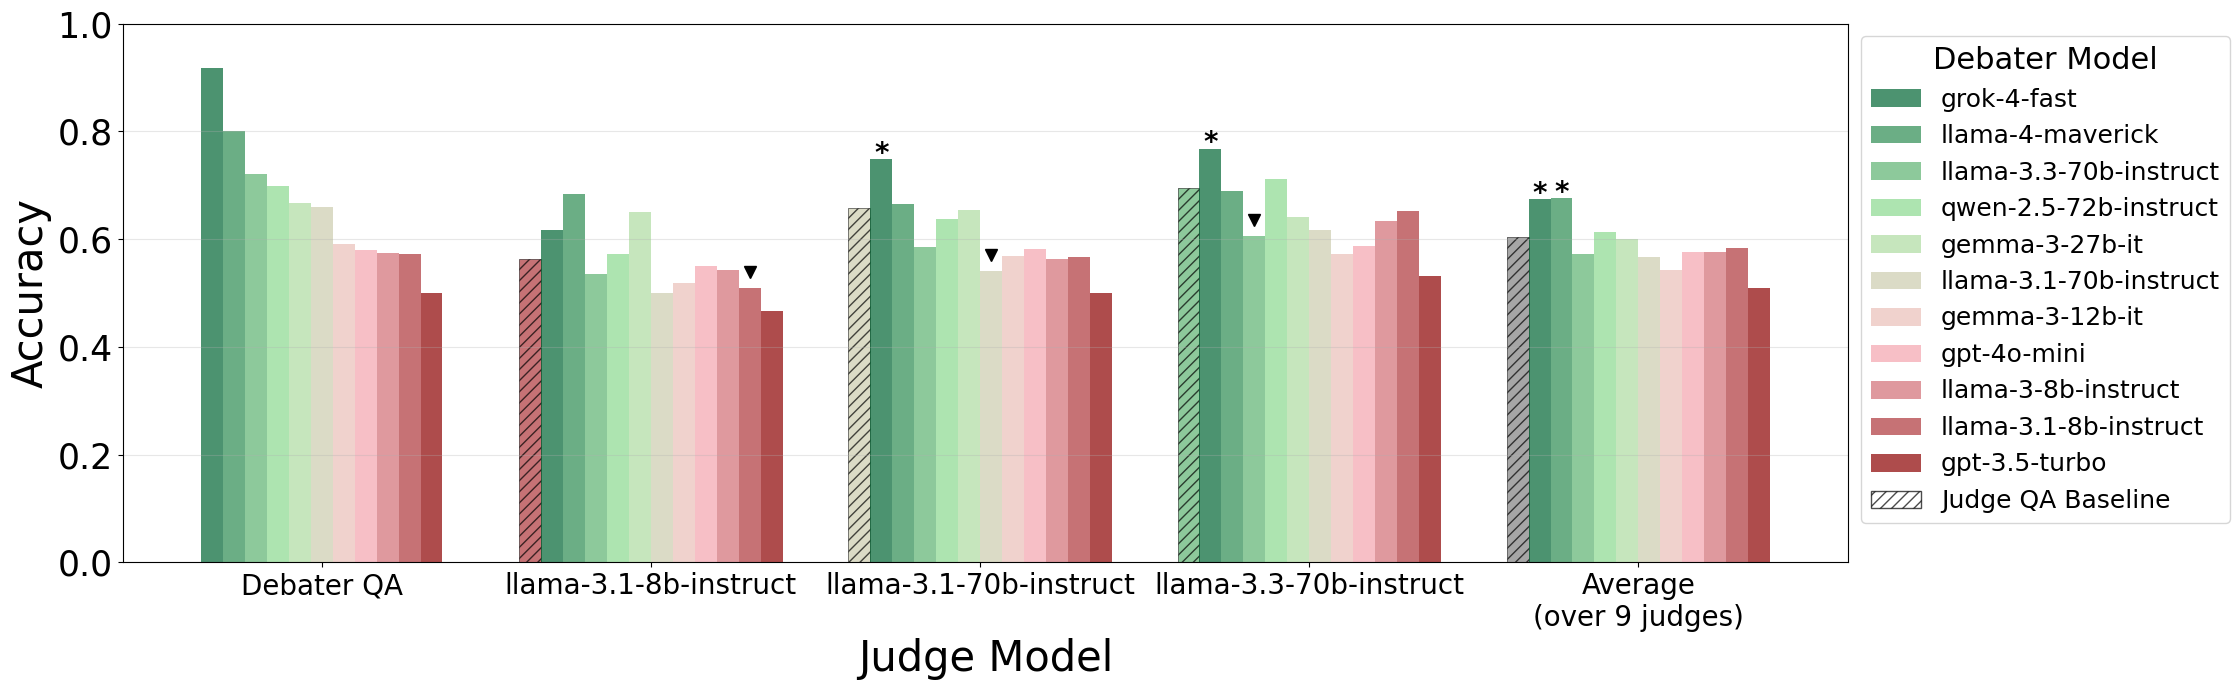

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest

# ============================================================================
# Configuration
# ============================================================================
judge_models_to_show = ['meta-llama/llama-3.3-70b-instruct', 
                        'meta-llama/llama-3.1-70b-instruct', 
                        'meta-llama/llama-3.1-8b-instruct']

# ============================================================================
# Data Preparation
# ============================================================================
run_mapping = pd.DataFrame(data['runs'])
merged = aggregate_acc.merge(run_mapping, left_on='name', right_on='verdict_run_id')

# ============================================================================
# Significance Testing
# ============================================================================
def test_significance(verdict_correct, verdict_total, baseline_correct, baseline_total):
    count = np.array([verdict_correct, baseline_correct])
    nobs = np.array([verdict_total, baseline_total])
    z_stat, p_value = proportions_ztest(count, nobs, alternative='larger')
    return p_value < 0.05

# Test debater models vs overall judge QA
judge_qa_correct_total = aggregate_acc['judge_qa_n_correct'].sum()
judge_qa_total = aggregate_acc['n_judge_qa_not_null'].sum()

significant_debaters = {}
for debater_model in aggregate_acc['config_debater_model_debates'].unique():
    rows = aggregate_acc[aggregate_acc['config_debater_model_debates'] == debater_model]
    significant_debaters[debater_model] = test_significance(
        rows['verdict_n_correct'].sum(), rows['n_verdict_not_null'].sum(),
        judge_qa_correct_total, judge_qa_total
    )

# Test each judge-debater pair
significant_judge_debater_pairs = {}
# print("Significant judge-debater pairs:")
for judge_model in aggregate_acc['config_judge_model_verdicts'].unique():
    for debater_model in aggregate_acc['config_debater_model_debates'].unique():
        pair_rows = aggregate_acc[
            (aggregate_acc['config_judge_model_verdicts'] == judge_model) &
            (aggregate_acc['config_debater_model_debates'] == debater_model)
        ]
        
        if len(pair_rows) > 0:
            judge_qa_correct = pair_rows['judge_qa_n_correct'].sum()
            judge_qa_total = pair_rows['n_judge_qa_not_null'].sum()
            verdict_correct = pair_rows['verdict_n_correct'].sum()
            verdict_total = pair_rows['n_verdict_not_null'].sum()
            
            if judge_qa_total > 0 and verdict_total > 0:
                is_sig = test_significance(verdict_correct, verdict_total, judge_qa_correct, judge_qa_total)
                significant_judge_debater_pairs[(judge_model, debater_model)] = is_sig
                
                if is_sig:
                    j_short = judge_model.split('/')[-1]
                    d_short = debater_model.split('/')[-1]
                    v_acc = verdict_correct / verdict_total
                    j_acc = judge_qa_correct / judge_qa_total
                    # print(f"  {j_short} + {d_short}: {v_acc:.3f} vs {j_acc:.3f}")

# ============================================================================
# Helper Functions
# ============================================================================
def get_model_short_name(full_name):
    return full_name.split('/')[-1] if '/' in full_name else full_name

def calculate_bar_offset(bar_idx, n_bars, bar_width):
    return (bar_idx - n_bars / 2 + 0.5) * bar_width

def add_significance_star(ax, x, y, fontsize=20):
    ax.text(x, y + 0.01, '*', ha='center', va='center', fontsize=fontsize, fontweight='bold')

# ============================================================================
# Build Labels and Colors
# ============================================================================
debate_run_id_labels = {}
for debate_run_id in merged['debate_run_id'].unique():
    with open(f"../results/debates/{debate_run_id}.jsonl", "r") as f:
        debate_record = json.loads(f.readline())
    debater_model = debate_record['config']['debater_model']
    debate_run_id_labels[debate_run_id] = get_model_short_name(debater_model)

colors_list = [
    (0.0, (0.0, 0.4, 0.2)), (0.33, (0.6, 0.9, 0.6)),
    (0.67, (1.0, 0.71, 0.76)), (1.0, (0.55, 0.0, 0.0))
]
custom_cmap = mcolors.LinearSegmentedColormap.from_list('green_yellow_red', colors_list)

# ============================================================================
# Prepare Plot Data
# ============================================================================
plot_data = merged[merged['run_idx'] == 0].copy()

# Sort debate runs by QA accuracy
debater_scores = plot_data.groupby('debate_run_id')['debater_qa_acc'].first().sort_values(ascending=False)
debate_run_ids = debater_scores.index.tolist()

# Map judge models to their matching debater (for coloring)
judge_to_debate_run = {}
for judge_model in plot_data['model'].unique():
    for debate_idx, debate_run_id in enumerate(debate_run_ids):
        debate_row = plot_data[plot_data['debate_run_id'] == debate_run_id].iloc[0]
        debater_short = debate_run_id_labels[debate_run_id]
        judge_short = get_model_short_name(judge_model)
        if debater_short == judge_short:
            judge_to_debate_run[judge_model] = debate_idx
            break

# Filter and sort judge models
judge_models = sorted(plot_data['model'].unique(), 
                     key=lambda x: judge_to_debate_run.get(x, -1), 
                     reverse=True)
if judge_models_to_show:
    judge_models = [jm for jm in judge_models if jm in judge_models_to_show]

# ============================================================================
# Setup Plot
# ============================================================================
n_judges = len(judge_models)
n_debates = len(debate_run_ids)
group_width = 0.8
bar_width = group_width / (n_debates + 1)

fig, ax = plt.subplots(figsize=(25, 7))
colors = custom_cmap(np.linspace(0.0, 1.0, n_debates))
    
x_labels = ['Debater QA'] + judge_models
x_positions = np.arange(len(x_labels))

# ============================================================================
# Plot: Debater QA Baseline (leftmost group)
# ============================================================================
for i, debate_run_id in enumerate(debate_run_ids):
    row = plot_data[plot_data['debate_run_id'] == debate_run_id].iloc[0]
    offset = calculate_bar_offset(i, n_debates, bar_width)
    ax.bar(offset, row['debater_qa_acc'], bar_width, color=colors[i], alpha=0.7)
    
# ============================================================================
# Plot: Judge Model Groups (QA baseline + verdicts for each debater)
# ============================================================================
for judge_idx, judge_model in enumerate(judge_models):
    x_pos = judge_idx + 1
    judge_color_idx = judge_to_debate_run.get(judge_model, None)
    
    # Judge QA baseline bar (hatched, colored by matching debater or gray if no match)
    judge_row = plot_data[plot_data['model'] == judge_model].iloc[0]
    qa_offset = calculate_bar_offset(0, n_debates + 1, bar_width)
    qa_color = colors[judge_color_idx] if judge_color_idx is not None else 'gray'
    ax.bar(x_pos + qa_offset, judge_row['judge_qa_acc'], bar_width, 
           color=qa_color, alpha=0.7, hatch='///', 
           edgecolor='black', linewidth=0.5)
    
    # Arrow marker above matching debater verdict (only if there's a match)
    if judge_color_idx is not None:
        verdict_offset = calculate_bar_offset(judge_color_idx + 1, n_debates + 1, bar_width)
        matching_row = plot_data[(plot_data['model'] == judge_model) & 
                                (plot_data['debate_run_id'] == debate_run_ids[judge_color_idx])]
        if len(matching_row) > 0:
            verdict_acc = matching_row['verdict_acc'].values[0]
            ax.plot(x_pos + verdict_offset, verdict_acc + 0.03, marker='v', 
                   color='black', markersize=8)
    
    # Verdict bars for each debater
    for i, debate_run_id in enumerate(debate_run_ids):
        verdict_row = plot_data[(plot_data['model'] == judge_model) & 
                               (plot_data['debate_run_id'] == debate_run_id)]
        if len(verdict_row) > 0:
            verdict_acc = verdict_row['verdict_acc'].values[0]
            debater_model = verdict_row['config_debater_model_debates'].values[0]
            offset = calculate_bar_offset(i + 1, n_debates + 1, bar_width)
            
            ax.bar(x_pos + offset, verdict_acc, bar_width, color=colors[i], alpha=0.7)
            
            if significant_judge_debater_pairs.get((judge_model, debater_model), False):
                add_significance_star(ax, x_pos + offset, verdict_acc)
    
# ============================================================================
# Plot: Average Group (rightmost)
# ============================================================================
x_pos = len(judge_models) + 1
x_labels.append('Average\n(over 9 judges)')

# Average QA baseline (gray, hatched)
qa_offset = calculate_bar_offset(0, n_debates + 1, bar_width)
ax.bar(x_pos + qa_offset, qa_avg_minus2, bar_width, color='gray', alpha=0.7, 
       hatch='///', edgecolor='black', linewidth=0.5)

# Average verdicts for each debater
for i, debate_run_id in enumerate(debate_run_ids):
    debater_model = plot_data[plot_data['debate_run_id'] == debate_run_id].iloc[0]['config_debater_model_debates']
    verdict_val = verdict_avg_minus2[debater_model]
    offset = calculate_bar_offset(i + 1, n_debates + 1, bar_width)
    
    ax.bar(x_pos + offset, verdict_val, bar_width, color=colors[i], alpha=0.7)
    
    if significant_debaters.get(debater_model, False):
        add_significance_star(ax, x_pos + offset, verdict_val)

# ============================================================================
# Format Plot
# ============================================================================
from matplotlib.patches import Patch

x_positions = np.arange(len(x_labels))
ax.set_xlabel('Judge Model', fontsize=30)
ax.set_ylabel('Accuracy', fontsize=30)
ax.set_xticks(x_positions)
ax.set_xticklabels([get_model_short_name(label) for label in x_labels], 
                   rotation=0, fontsize=20)
ax.tick_params(axis='y', labelsize=25)

# Legend
legend_elements = [Patch(facecolor=colors[i], alpha=0.7, 
                         label=debate_run_id_labels[debate_run_ids[i]]) 
                  for i in range(n_debates)]
legend_elements.append(Patch(facecolor='white', alpha=0.7, hatch='///', 
                            edgecolor='black', label='Judge QA Baseline'))

ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), 
         title='Debater Model', fontsize=18, title_fontsize=22)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

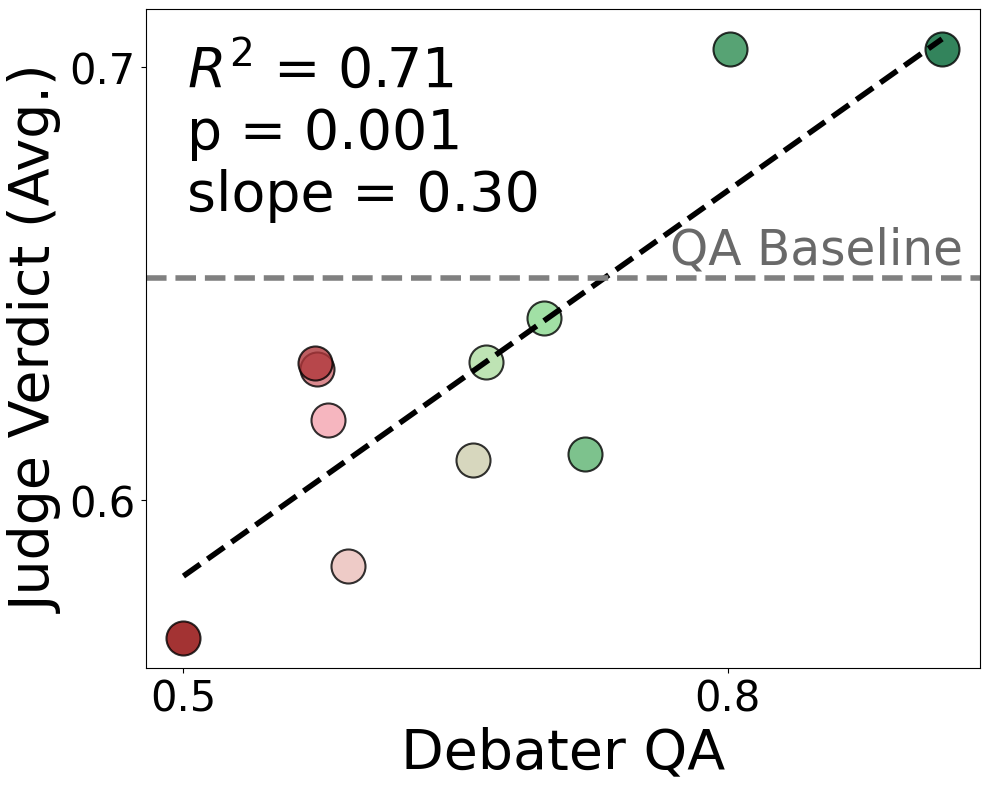

Linear Regression:
  Slope: 0.2967
  Intercept: 0.4342
  R-squared: 0.7063
  P-value: 1.1987e-03
  Std Error: 0.0638


In [11]:
from scipy import stats

fig, ax = plt.subplots(figsize=(10, 8))

debater_data = plot_data.groupby('config_debater_model_debates').agg({
    'debater_qa_acc': 'first',
    'verdict_acc': 'mean'
}).reset_index()
debater_data = debater_data.sort_values('debater_qa_acc', ascending=False)

avg_judge_qa = plot_data['judge_qa_acc'].mean()

colors = custom_cmap(np.linspace(0.0, 1.0, len(debater_data)))

for i, (_, row) in enumerate(debater_data.iterrows()):
    ax.scatter(row['debater_qa_acc'], row['verdict_acc'], s=600, alpha=0.8, color=colors[i], edgecolors='black', linewidth=1.5)

slope, intercept, r_value, p_value, std_err = stats.linregress(debater_data['debater_qa_acc'], debater_data['verdict_acc'])
x_fit = np.linspace(debater_data['debater_qa_acc'].min(), debater_data['debater_qa_acc'].max(), 100)
y_fit = slope * x_fit + intercept
ax.plot(x_fit, y_fit, 'k--', linewidth=4)

ax.axhline(avg_judge_qa, color='gray', linestyle='--', linewidth=4)

ax.set_xlabel('Debater QA', fontsize=40)
ax.set_ylabel('Judge Verdict (Avg.)', fontsize=40)
ax.tick_params(axis='both', labelsize=30)
ax.set_xticks([0.5, 0.80])
ax.locator_params(axis='y', nbins=2)

ax.text(ax.get_xlim()[1] * 0.99, avg_judge_qa + 0.001, 'QA Baseline', 
        fontsize=35, ha='right', va='bottom', color='dimgray')

ax.text(0.05, 0.95, f'$R^2$ = {r_value**2:.2f}\np = {p_value:.3f}\nslope = {slope:.2f}', 
        transform=ax.transAxes, fontsize=40, va='top')

plt.tight_layout()
plt.show()

print(f"Linear Regression:")
print(f"  Slope: {slope:.4f}")
print(f"  Intercept: {intercept:.4f}")
print(f"  R-squared: {r_value**2:.4f}")
print(f"  P-value: {p_value:.4e}")
print(f"  Std Error: {std_err:.4f}")


In [11]:
best_expert_model = debater_data.iloc[0]['config_debater_model_debates']
best_expert_qa_acc = debater_data.iloc[0]['debater_qa_acc']
best_expert_verdict_acc = verdict_avg_minus2[best_expert_model]
delta = best_expert_verdict_acc - best_expert_qa_acc
gap_recovered = (best_expert_verdict_acc - qa_avg_minus2) / (best_expert_qa_acc - qa_avg_minus2)

print(f"Best expert model: {best_expert_model}")
print(f"Debater QA acc: {best_expert_qa_acc:.4f}")
print(f"Average judge QA acc (minus top 2): {qa_avg_minus2:.4f}")
print(f"Average verdict acc (across judges, minus top 2): {best_expert_verdict_acc:.4f}")
print(f"Delta (verdict_acc - debater_qa_acc): {delta:.4f}")
print(f"Gap recovered: {gap_recovered:.4f}")


Best expert model: x-ai/grok-4-fast
Debater QA acc: 0.9219
Average judge QA acc (minus top 2): 0.6048
Average verdict acc (across judges, minus top 2): 0.6724
Delta (verdict_acc - debater_qa_acc): -0.2495
Gap recovered: 0.2130


## Table 1

In [ ]:
# for each of these we're going to get the avg across nine judges on grok-4-fast and llama-4-maverick as debaters.
# also add the average QA for each on each row even though it shouldn't differ across conditions.
# also include the samples counts that went into the averages. 

# 6irkzm1: baseline...minimal debater prompt, minimal judge prompt...but note that we're only going to get the grok-4-fast and llama-4-maverick debater results, and only for the 9 judge models
# the rest only have 2 debaters and 9 judges
# gp61skb: full debater prompt (debate game), minimal judge prompt 
# aa5ppcz: minimal debater prompt, CoT judge prompt (generic)
# xod46dv: full debater prompt (debate game), CoT prompt (generic)
# 9sd7xt3 full debater prompt (debate game), (CoT prompt (debate game aware)



In [153]:
verdict_group_batches = {
    '6irkzm1': 'baseline (minimal debater, minimal judge)',
    'gp61skb': 'full debater prompt (debate game), minimal judge prompt',
    'aa5ppcz': 'minimal debater prompt, CoT judge prompt (generic)',
    'xod46dv': 'full debater prompt (debate game), CoT prompt (generic)',
    '9sd7xt3': 'full debater prompt (debate game), CoT prompt (debate game aware)'
}

debater_models = ['x-ai/grok-4-fast', 'meta-llama/llama-4-maverick']

judge_models = [
    'google/gemma-3-12b-it',
    'google/gemma-3-27b-it',
    'meta-llama/llama-3-8b-instruct',
    'meta-llama/llama-3.1-8b-instruct',
    'meta-llama/llama-3.1-70b-instruct',
    'meta-llama/llama-3.3-70b-instruct',
    'openai/gpt-3.5-turbo',
    'openai/gpt-4o-mini',
    'qwen/qwen-2.5-72b-instruct'
]

all_verdict_ids = []
batch_mapping = {}
for batch_id, description in verdict_group_batches.items():
    verdict_ids, _ = get_verdict_ids_from_batch(batch_id)
    all_verdict_ids.extend(verdict_ids)
    for vid in verdict_ids:
        batch_mapping[vid] = batch_id

verdicts_df = prepare_df(specific_verdict_ids=all_verdict_ids)
verdicts_df = verdicts_df[
    (verdicts_df['is_correct_qa_judge'].notnull()) & 
    (verdicts_df['is_correct_verdict'].notnull()) & 
    (verdicts_df['is_correct_qa_debater'].notnull())
]

verdicts_df = verdicts_df[
    (verdicts_df['config_model_name_qa_judge'] != 'meta-llama/llama-4-scout') & 
    (verdicts_df['config_model_name_qa_debater'] != 'meta-llama/llama-4-scout')
]
verdicts_df = verdicts_df[
    (verdicts_df['config_model_name_qa_judge'] != 'meta-llama/llama-3.1-405b-instruct') & 
    (verdicts_df['config_model_name_qa_debater'] != 'meta-llama/llama-3.1-405b-instruct')
]

verdicts_df = verdicts_df[
    (verdicts_df['config_model_name_qa_debater'].isin(debater_models)) &
    (verdicts_df['config_judge_model_verdicts'].isin(judge_models))
]

aggregate_acc = aggregate_by_fields(verdicts_df, fields=['verdict_run_id_verdicts'])
aggregate_acc = aggregate_acc.merge(
    verdicts_df[['verdict_run_id_verdicts', 'config_judge_model_verdicts', 'config_debater_model_debates']].drop_duplicates(),
    left_on='name',
    right_on='verdict_run_id_verdicts',
    how='inner'
)

aggregate_acc['batch_id'] = aggregate_acc['name'].map(batch_mapping)

results = []
for batch_id, description in verdict_group_batches.items():
    batch_agg = aggregate_acc[aggregate_acc['batch_id'] == batch_id]
    
    for debater_model in debater_models:
        debater_agg = batch_agg[batch_agg['config_debater_model_debates'] == debater_model]
        
        if len(debater_agg) == 0:
            continue
        
        temp = debater_agg[~debater_agg['config_judge_model_verdicts'].isin(['x-ai/grok-4-fast', 'meta-llama/llama-4-maverick'])]
        
        if len(temp) == 0:
            continue
        
        verdict_avg = temp['verdict_acc'].mean()
        judge_qa_avg = temp['judge_qa_acc'].mean()
        debater_qa_avg = temp['debater_qa_acc'].mean()
        
        verdict_n_correct = int(temp['verdict_n_correct'].sum())
        verdict_n_total = int(temp['n_verdict_not_null'].sum())
        judge_qa_n_correct = int(temp['judge_qa_n_correct'].sum())
        judge_qa_n_total = int(temp['n_judge_qa_not_null'].sum())
        debater_qa_n_correct = int(temp['debater_qa_n_correct'].sum())
        debater_qa_n_total = int(temp['n_debater_qa_not_null'].sum())
        
        results.append({
            'batch_id': batch_id,
            'description': description,
            'debater_model': debater_model,
            'verdict_acc': verdict_avg,
            'judge_qa_acc': judge_qa_avg,
            'debater_qa_acc': debater_qa_avg,
            'verdict_n_correct': verdict_n_correct,
            'verdict_n_total': verdict_n_total,
            'judge_qa_n_correct': judge_qa_n_correct,
            'judge_qa_n_total': judge_qa_n_total,
            'debater_qa_n_correct': debater_qa_n_correct,
            'debater_qa_n_total': debater_qa_n_total
        })

results_df = pd.DataFrame(results)
results_df


/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/../analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


,batch_id,description,debater_model,verdict_acc,judge_qa_acc,debater_qa_acc,verdict_n_correct,verdict_n_total,judge_qa_n_correct,judge_qa_n_total,debater_qa_n_correct,debater_qa_n_total
0,6irkzm1,"baseline (minimal debater, minimal judge)",x-ai/grok-4-fast,0.672371,0.599169,0.922619,1132,1681,1009,1681,1551,1681
1,6irkzm1,"baseline (minimal debater, minimal judge)",meta-llama/llama-4-maverick,0.677808,0.605751,0.798850,1145,1690,1025,1690,1350,1690
2,gp61skb,"full debater prompt (debate game), minimal jud...",x-ai/grok-4-fast,0.706880,0.604963,0.921981,1216,1718,1040,1718,1584,1718
3,gp61skb,"full debater prompt (debate game), minimal jud...",meta-llama/llama-4-maverick,0.688936,0.602105,0.800995,1175,1703,1028,1703,1364,1703
4,aa5ppcz,"minimal debater prompt, CoT judge prompt (gene...",x-ai/grok-4-fast,0.656339,0.601321,0.923364,1117,1695,1023,1695,1565,1695
5,aa5ppcz,"minimal debater prompt, CoT judge prompt (gene...",meta-llama/llama-4-maverick,0.676399,0.602395,0.797842,1145,1692,1021,1692,1350,1692
6,xod46dv,"full debater prompt (debate game), CoT prompt ...",x-ai/grok-4-fast,0.703866,0.602466,0.923139,1211,1717,1036,1717,1585,1717
7,xod46dv,"full debater prompt (debate game), CoT prompt ...",meta-llama/llama-4-maverick,0.682843,0.605661,0.799347,1145,1675,1016,1675,1339,1675
8,9sd7xt3,"full debater prompt (debate game), CoT prompt ...",x-ai/grok-4-fast,0.705626,0.605797,0.923480,1198,1699,1027,1699,1569,1699
9,9sd7xt3,"full debater prompt (debate game), CoT prompt ...",meta-llama/llama-4-maverick,0.676218,0.601253,0.799572,1086,1605,962,1605,1283,1605


In [212]:
def parse_prompts(description):
    if 'minimal debater' in description.lower():
        debater_prompt = 'base'
    elif 'full debater' in description.lower():
        debater_prompt = 'debate game'
    else:
        debater_prompt = 'Unknown'
    
    if 'minimal judge' in description.lower():
        judge_prompt = 'base'
    elif 'cot judge prompt (generic)' in description.lower():
        judge_prompt = 'CoT (generic)'
    elif 'cot prompt (generic)' in description.lower():
        judge_prompt = 'CoT (generic)'
    elif 'cot prompt (debate game aware)' in description.lower():
        judge_prompt = 'CoT (game aware)'
    else:
        judge_prompt = 'Unknown'
    
    return debater_prompt, judge_prompt

table_data = []
base_verdict_avg = None

for batch_id in verdict_group_batches.keys():
    batch_results = results_df[results_df['batch_id'] == batch_id]
    debater_prompt, judge_prompt = parse_prompts(verdict_group_batches[batch_id])
    
    grok_row = batch_results[batch_results['debater_model'] == 'x-ai/grok-4-fast']
    llama_row = batch_results[batch_results['debater_model'] == 'meta-llama/llama-4-maverick']
    
    if len(grok_row) == 0 or len(llama_row) == 0:
        continue
    
    grok_data = grok_row.iloc[0]
    llama_data = llama_row.iloc[0]
    
    verdict_grok = grok_data['verdict_acc']
    verdict_llama = llama_data['verdict_acc']
    avg_verdict = (verdict_grok + verdict_llama) / 2
    
    if base_verdict_avg is None:
        base_verdict_avg = avg_verdict
        delta = '--'
    else:
        delta = f"{((avg_verdict - base_verdict_avg) * 100):+.1f}"
    
    table_data.append({
        'Debater Prompt': debater_prompt,
        'Judge Prompt': judge_prompt,
        'Verdict %\n(llama-4-maverick)': verdict_llama * 100,
        'Verdict %\n(grok-4-fast)': verdict_grok * 100,
        'Avg Verdict %': avg_verdict * 100,
        'Δ from base %': delta
    })

table_df = pd.DataFrame(table_data)

debater_order = {'base': 0, 'Debate Game': 1}
judge_order = {'base': 0, 'CoT (generic)': 1, 'CoT (debate game aware)': 2}

table_df['_debater_sort'] = table_df['Debater Prompt'].map(debater_order)
table_df['_judge_sort'] = table_df['Judge Prompt'].map(judge_order)
table_df = table_df.sort_values(['_debater_sort', '_judge_sort'])
table_df = table_df.drop(columns=['_debater_sort', '_judge_sort'])

for col in ['Verdict %\n(llama-4-maverick)', 'Verdict %\n(grok-4-fast)', 'Avg Verdict %']:
    if col in table_df.columns:
        table_df[col] = table_df[col].apply(lambda x: f"{x:.1f}" if isinstance(x, (int, float)) else x)

table_df_display = table_df.copy()
table_df_display.columns = [
    'Debater Prompt', 
    'Judge Prompt', 
    'Verdict % (llama-4-maverick)', 
    'Verdict % (grok-4-fast)', 
    'Avg Verdict %', 
    'Δ from base %'
]

from IPython.display import HTML
display(HTML(table_df_display.to_html(escape=False, index=False).replace('\\n', '<br>')))


Debater Prompt,Judge Prompt,Verdict % (llama-4-maverick),Verdict % (grok-4-fast),Avg Verdict %,Δ from base %
base,base,67.8,67.2,67.5,--
base,CoT (generic),67.6,65.6,66.6,-0.9
debate game,base,68.9,70.7,69.8,+2.3
debate game,CoT (generic),68.3,70.4,69.3,+1.8
debate game,CoT (game aware),67.6,70.6,69.1,+1.6
